In [2]:
# 那就先给数据读出来再做分析

import numpy as np

class SQGData:
    def __init__(self, truth_path='SQG.npy', noise_path='inverted_SQG.npy', data_std=2660.0):
        """
        初始化并加载SQG数据。
        参数：
            truth_path : str  真值文件路径
            noise_path : str  噪声或预测文件路径
            data_std   : float 用于标准化的标准差常数
        """
        # 读取原始数据
        self.truth_raw = np.load(truth_path)
        self.noise_raw = np.load(noise_path)
        
        # 检查形状一致性
        assert self.truth_raw.shape == self.noise_raw.shape, "Truth 和 Noise 数据形状不一致！"
        
        # 保存形状信息
        self.shape = self.truth_raw.shape   # (time, levels, dx, dy)
        self.time, self.levels, self.dx, self.dy = self.shape
        
        # 创建标准化版本
        self.data_std = data_std
        self.truth_norm = self.truth_raw / data_std
        self.noise_norm = self.noise_raw / data_std

        print(f"✅ SQG 数据加载完成: shape = {self.shape}, data_std = {data_std}")

    # ------------------------------------------------------------------
    def get_field(self, dataset='noise', t=None, level=0, normalized=False):
        """
        获取某个或多个时间步、层的数据。
        t: 可以是 int 或 slice 或 list
        """
        assert dataset in ['truth', 'noise'], "dataset 必须是 'truth' 或 'noise'"

        if dataset == 'truth':
            data = self.truth_norm if normalized else self.truth_raw
        else:
            data = self.noise_norm if normalized else self.noise_raw

        if t is None:
            return data[:, level]          # 所有时间步 (time, dx, dy)
        else:
            return data[t, level]          # 支持 int、list、slice






In [3]:
sqg = SQGData('SQG.npy', 'inverted_SQG.npy')
noise0 = sqg.get_field()
type(noise0)


✅ SQG 数据加载完成: shape = (1001, 2, 64, 64), data_std = 2660.0


numpy.ndarray

“像素分布高斯”与“latent 向量高斯”

我要验证的是哪个问题？

研究单帧的样本像素是否符合高斯分布
研究 SQG 场样本（truth 或生成样本）的空间高斯性与相关结构，并与 latent 空间对比。

我会先去找方法，确定以后在进行验证
方法：
https://doi.org/10.1016/j.jmva.2010.04.015

level0和level1分开进行处理

统一先做level0

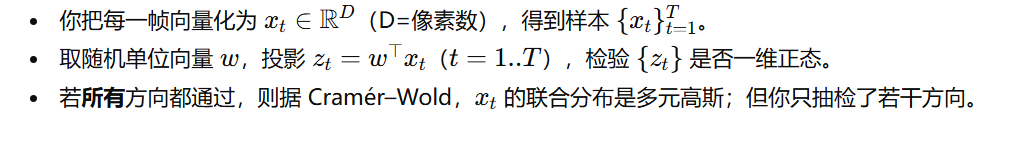

还需要做什么？

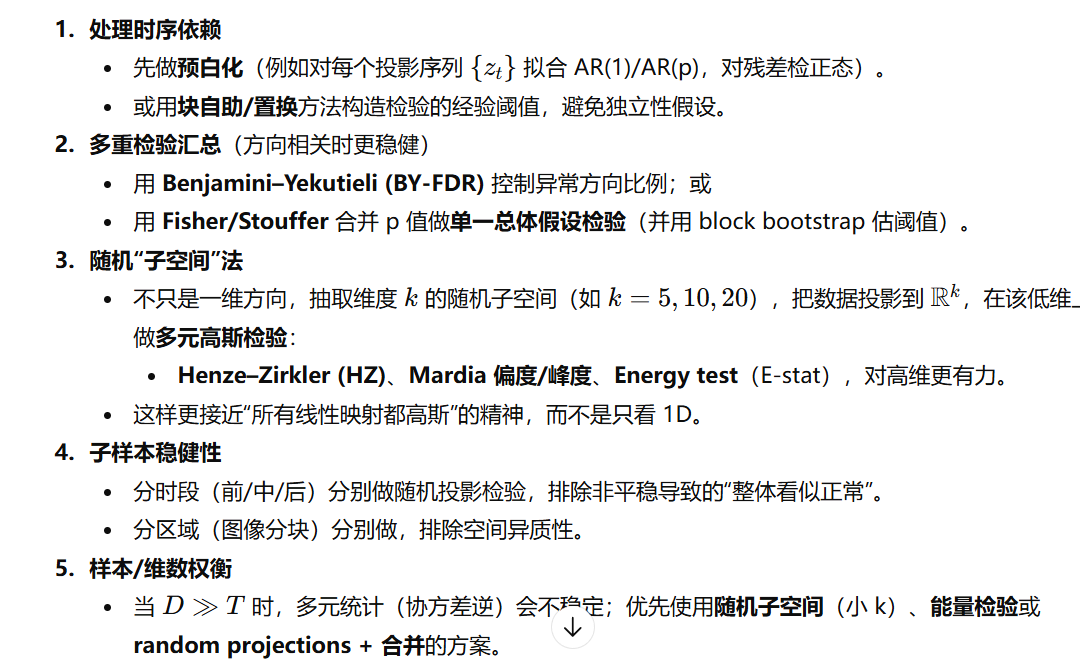



# 证明线性Or非线性correlation

我们现在已经采用了2D ACF+径向平均，并且已经得出结论是线性不相关的。

但是我们的方案假设是没有被证明通过的，要命。

我们现在补做，希望一切顺利！


在单次有限样本下，平稳/各向同性从逻辑上就难以被“证明”；统计学的正确做法是明确假设→做诊断→在违背时调整方法。

你能做的最强动作，是给出一套相互印证的诊断证据，让评审相信：把你的 2D ACF 与径向平均当作“各向同性近似下的合理摘要”是有依据的；若不成立，你已提供了方向性/局部分析与稳健性对比。

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
from scipy.ndimage import gaussian_filter

def _detrend_and_standardize(frames, local=False, local_sigma=0):
    """
    对帧序列去趋势并标准化。
    frames: (K, X, Y)
    local=False: 仅全局去均值、全局标准差
    local=True: 先用高斯滤波提取趋势(均值场)，再除以局部标准差（更严格）
    """
    K, X, Y = frames.shape
    F = frames.astype(np.float64)
    if not local:
        F = F - F.mean()
        std = F.std()
        if std > 0:
            F = F / std
        return F
    else:
        # 局部均值/方差（用高斯平滑做缓慢变化项）
        if local_sigma <= 0:
            local_sigma = max(3, min(X, Y)//16)  # 一个比较稳的缺省
        mu = np.stack([gaussian_filter(F[k], sigma=local_sigma) for k in range(K)], axis=0)
        R = F - mu
        # 局部标准差：先局部二阶矩，再减去mu^2
        m2 = np.stack([gaussian_filter(R[k]**2, sigma=local_sigma) for k in range(K)], axis=0)
        s = np.sqrt(np.clip(m2, 0, None))
        s[s == 0] = 1.0
        Z = R / s
        # 兜底全局标准化一次
        Z = (Z - Z.mean()) / (Z.std() + 1e-12)
        return Z

def _acf2d(img):
    """
    单帧2D自相关，wrap边界，归一化C(0,0)=1
    """
    c = correlate2d(img - img.mean(), img - img.mean(), mode='full', boundary='wrap')
    c = c / (np.max(c) + 1e-12)
    return c

def _radial_average(acf2d, r_max=None):
    H, W = acf2d.shape
    cx, cy = H//2, W//2
    y, x = np.indices(acf2d.shape)
    r = np.sqrt((y - cx)**2 + (x - cy)**2)
    if r_max is None:
        r_max = int(r.max())
    rb = r.astype(np.int32)
    radial = np.zeros(r_max+1, dtype=np.float64)
    counts = np.zeros(r_max+1, dtype=np.int64)
    np.add.at(radial, rb, acf2d)
    np.add.at(counts, rb, 1)
    counts[counts == 0] = 1
    radial = radial / counts
    return radial[:r_max+1]

def _directional_profiles(acf2d, n_angles=8, r_max=None):
    """
    取若干方向的ACF曲线：rho(r, theta_m)
    用极坐标分桶（半径整值+角度整桶），返回矩阵形状 (n_angles, r_bins)
    """
    H, W = acf2d.shape
    cy, cx = H//2, W//2
    yy, xx = np.indices(acf2d.shape)
    ry = yy - cy
    rx = xx - cx
    r = np.sqrt(ry**2 + rx**2)
    if r_max is None:
        r_max = int(r.max())
    rbin = r.astype(np.int32)
    theta = np.arctan2(ry, rx)  # [-pi, pi]
    # 仅用 0..pi（因为ACF是偶函数，对称即可），把角度映射到[0, pi)
    theta = np.mod(theta, np.pi)
    # 分桶
    ang_edges = np.linspace(0, np.pi, n_angles+1, endpoint=True)
    profiles = np.zeros((n_angles, r_max+1), dtype=np.float64)
    counts = np.zeros_like(profiles, dtype=np.int64)
    for m in range(n_angles):
        mask_ang = (theta >= ang_edges[m]) & (theta < ang_edges[m+1])
        rb = rbin[mask_ang]
        vals = acf2d[mask_ang]
        # 累加到半径桶
        np.add.at(profiles[m], rb, vals)
        np.add.at(counts[m], rb, 1)
    counts[counts == 0] = 1
    profiles = profiles / counts
    return profiles[:, :r_max+1]  # (n_angles, R)

def _subblocks_indices(X, Y, blocks=(2,2)):
    bx, by = blocks
    xs = np.linspace(0, X, bx+1, dtype=int)
    ys = np.linspace(0, Y, by+1, dtype=int)
    regions = []
    for i in range(bx):
        for j in range(by):
            regions.append((slice(xs[i], xs[i+1]), slice(ys[j], ys[j+1])))
    return regions

def _wss_block_diagnostics(frames, blocks=(2,2), acf_r0=8):
    """
    分块均值/方差 + 分块ACF一致性指标 Δ_{kℓ}
    返回：
      mu_k, std_k, ratio_std, delta_median
    """
    # 用第一帧（或平均帧）做空间统计更稳定
    F = frames.mean(axis=0)  # (X, Y)
    X, Y = F.shape
    regions = _subblocks_indices(X, Y, blocks=blocks)
    mus, stds = [], []
    acfs = []
    for slx, sly in regions:
        B = F[slx, sly]
        mus.append(B.mean())
        stds.append(B.std() + 1e-12)
        ac = _acf2d(B)
        # 取小滞后窗口内的acf向量作为“形状特征”
        H, W = ac.shape
        cy, cx = H//2, W//2
        yy, xx = np.indices(ac.shape)
        r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
        mask = (r <= acf_r0)
        acfs.append(ac[mask].ravel())
    mus = np.array(mus)
    stds = np.array(stds)
    ratio_std = stds.max() / stds.min()
    # ACF形状一致性：两两欧氏距离的平方平均
    acf_mat = np.vstack(acfs)
    K = acf_mat.shape[0]
    deltas = []
    for i in range(K):
        for j in range(i+1, K):
            # 归一化后比较形状
            ai = acf_mat[i]
            aj = acf_mat[j]
            ai = (ai - ai.mean()) / (ai.std() + 1e-12)
            aj = (aj - aj.mean()) / (aj.std() + 1e-12)
            d = np.mean((ai - aj)**2)
            deltas.append(d)
    delta_median = np.median(deltas) if deltas else 0.0
    return mus, stds, ratio_std, delta_median

def _spectrum_and_kappa(frames, smooth_sigma=1.5):
    """
    频域周期图 + 结构张量特征值比 kappa
    用平均帧的FFT估计谱，作轻度高斯平滑后计算二阶矩矩阵M
    """
    F = frames.mean(axis=0)
    F = F - F.mean()
    S = np.abs(np.fft.fftshift(np.fft.fft2(F)))**2  # 周期图
    if smooth_sigma is not None and smooth_sigma > 0:
        Ssm = gaussian_filter(S, sigma=smooth_sigma)
    else:
        Ssm = S
    X, Y = Ssm.shape
    # 频率坐标（单位化到 [-1,1]）
    fy = np.linspace(-1, 1, X)
    fx = np.linspace(-1, 1, Y)
    FY, FX = np.meshgrid(fy, fx, indexing='ij')
    # 结构张量
    Mxx = np.sum((FX**2) * Ssm)
    Myy = np.sum((FY**2) * Ssm)
    Mxy = np.sum((FX*FY) * Ssm)
    M = np.array([[Mxx, Mxy], [Mxy, Myy]], dtype=np.float64)
    evals = np.linalg.eigvalsh(M)
    evals = np.sort(evals)
    lam_min, lam_max = evals[0], evals[-1]
    kappa = (lam_max / (lam_min + 1e-12))
    return S, Ssm, kappa

def spatial_correlation_diagnostics(field,
                                    average_frames=10,
                                    blocks=(2,2),
                                    n_angles=8,
                                    r_max=None,
                                    use_local_standardize=False,
                                    show_plots=True,
                                    thresholds=dict(
                                        mu_abs_max=0.1,      # |μ_k| ≤ 0.1
                                        std_ratio_max=1.5,   # max std / min std ≤ 1.5
                                        delta_median_max=0.05,# 分块ACF形状差异
                                        D_median_max=0.02,   # 方向性ACF离散度
                                        kappa_max=1.3        # 结构张量特征值比
                                    )):
    """
    基于 2D ACF + 径向平均 的“诊断—决策”实现（第一版核心）。
    输入
    ----
    field: (T, X, Y)
    average_frames: 取前K帧做平均与ACF，避免偶然噪声
    blocks: 分块个数( bx, by )
    n_angles: 方向性ACF的方向数
    r_max: 径向最大半径（None为自动）
    use_local_standardize: 是否使用局部趋势/尺度去除（更严格）
    show_plots: 是否绘图
    thresholds: 各诊断阈值（工程阈值，可在你的数据上微调）

    返回
    ----
    results: dict，含诊断指标、2D ACF、径向曲线、方向性曲线、谱图与决策结论
    """
    T, X, Y = field.shape
    K = min(average_frames, T)
    frames0 = field[:K].astype(np.float64)

    # 0) 去趋势与标准化
    frames = _detrend_and_standardize(frames0, local=use_local_standardize)

    # 1) WSS：分块均值/方差 + 2) 分块ACF形状一致性
    mu_k, std_k, std_ratio, delta_median = _wss_block_diagnostics(frames, blocks=blocks, acf_r0=8)

    # 3) 计算平均2D ACF与径向平均
    acf2d = np.zeros((2*X-1, 2*Y-1), dtype=np.float64)
    for i in range(K):
        acf2d += _acf2d(frames[i])
    acf2d /= K
    radial = _radial_average(acf2d, r_max=r_max)
    # 相关长度（1/e）
    corr_len = int(np.argmax(radial < np.exp(-1))) if np.any(radial < np.exp(-1)) else None

    # 3) 各向同性：方向性ACF离散度
    dir_profiles = _directional_profiles(acf2d, n_angles=n_angles, r_max=(len(radial)-1))
    # 只在“有效半径”（样本对足够多）评估；这里简化为前 1/3~1/2 的半径
    R = dir_profiles.shape[1]
    r_lo, r_hi = max(1, R//12), max(2, R//2)
    D_r = np.var(dir_profiles[:, r_lo:r_hi], axis=0)  # 每个半径桶的方向方差
    D_median = float(np.median(D_r))

    # 4) 频域：周期图 + 结构张量特征值比 kappa
    S, Ssm, kappa = _spectrum_and_kappa(frames, smooth_sigma=1.5)

    # 5) 决策：是否可把“径向平均”作为主要摘要
    th = thresholds
    wss_ok = (np.max(np.abs(mu_k)) <= th['mu_abs_max']) and (std_ratio <= th['std_ratio_max']) and (delta_median <= th['delta_median_max'])
    iso_ok = (D_median <= th['D_median_max']) and (kappa <= th['kappa_max'])

    if wss_ok and iso_ok:
        decision = "ACCEPT_RADIAL"  # 采用径向平均作为主要摘要
        note = ("诊断显示近似WSS与近似各向同性成立（分块均值/方差稳定、分块ACF形状一致、方向性离散度低、谱近似圆对称）。"
                "因此后续可使用径向平均ACF作为主要结果与拟合依据。")
    elif wss_ok and not iso_ok:
        decision = "KEEP_DIRECTIONAL"
        note = ("二阶平稳近似成立，但存在各向异性（方向性ACF离散度或谱椭圆率较高）。"
                "不应做径向平均作为推断依据，应保留方向族 ρ(r,θ) 或采用各向异性核建模。")
    elif (not wss_ok) and iso_ok:
        decision = "LOCAL_ANALYSIS"
        note = ("存在非平稳性（分块统计或分块ACF差异明显），尽管各向同性近似尚可。"
                "建议去趋势/局部标准化后做**局部**ACF/谱分析，或报告不同区域的径向曲线。")
    else:
        decision = "DIRECTIONAL_AND_LOCAL"
        note = ("同时存在非平稳与各向异性。径向平均仅作可视化参考，不用于推断；"
                "正文呈现方向性+局部结果，建模采用各向异性与局部平稳方法。")

    results = dict(
        # 你原函数的输出
        acf2d=acf2d,
        radial_correlation=radial,
        correlation_length=corr_len,
        # 新增诊断指标
        block_means=mu_k, 
        block_stds=std_k, 
        std_ratio=float(std_ratio),
        block_acf_shape_delta_median=float(delta_median),
        directional_profiles=dir_profiles,       # 形状 (n_angles, R)
        directional_dispersion_by_r=D_r,         # 每个半径的方向方差
        directional_dispersion_median=float(D_median),
        periodogram=S, periodogram_smooth=Ssm,
        kappa=float(kappa),
        # 决策
        decision=decision,
        decision_note=note,
        thresholds=thresholds,
        meta=dict(
            average_frames=K, blocks=blocks, n_angles=n_angles, r_range=(r_lo, r_hi),
            use_local_standardize=use_local_standardize
        )
    )

    if show_plots:
        fig, axs = plt.subplots(2, 3, figsize=(14, 8))
        # 2D ACF
        im0 = axs[0,0].imshow(acf2d, cmap='RdBu_r', origin='lower')
        axs[0,0].set_title("2D ACF (normalized)")
        plt.colorbar(im0, ax=axs[0,0], fraction=0.046, pad=0.04)

        # Radial
        axs[0,1].plot(radial, lw=1.5)
        axs[0,1].axhline(np.exp(-1), ls='--')
        if corr_len is not None:
            axs[0,1].axvline(corr_len, ls='--')
        axs[0,1].set_title("Radial ACF")
        axs[0,1].set_xlabel("r (px)")
        axs[0,1].set_ylabel("C(r)")

        # Directional profiles (r in [r_lo, r_hi))
        for m in range(dir_profiles.shape[0]):
            axs[0,2].plot(np.arange(r_lo, r_hi), dir_profiles[m, r_lo:r_hi], alpha=0.8)
        axs[0,2].set_title(f"Directional ACFs (n={n_angles})")
        axs[0,2].set_xlabel("r (px)")
        axs[0,2].set_ylabel("C(r)")

        # Periodogram
        im1 = axs[1,0].imshow(np.log1p(S), cmap='magma', origin='lower')
        axs[1,0].set_title("Periodogram log(1+S)")
        plt.colorbar(im1, ax=axs[1,0], fraction=0.046, pad=0.04)
        im2 = axs[1,1].imshow(np.log1p(Ssm), cmap='magma', origin='lower')
        axs[1,1].set_title(f"Smoothed Spectrum (κ={results['kappa']:.2f})")
        plt.colorbar(im2, ax=axs[1,1], fraction=0.046, pad=0.04)

        # WSS block stats
        axs[1,2].bar(np.arange(len(mu_k))-0.2, mu_k, width=0.4, label='μ_k')
        axs[1,2].bar(np.arange(len(mu_k))+0.2, std_k, width=0.4, label='σ_k')
        axs[1,2].set_title(f"WSS blocks: std_ratio={std_ratio:.2f}, Δ_med={delta_median:.3f}")
        axs[1,2].legend()

        plt.tight_layout()
        plt.show()

        print("【决策】", decision)
        print("说明：", note)

    return results


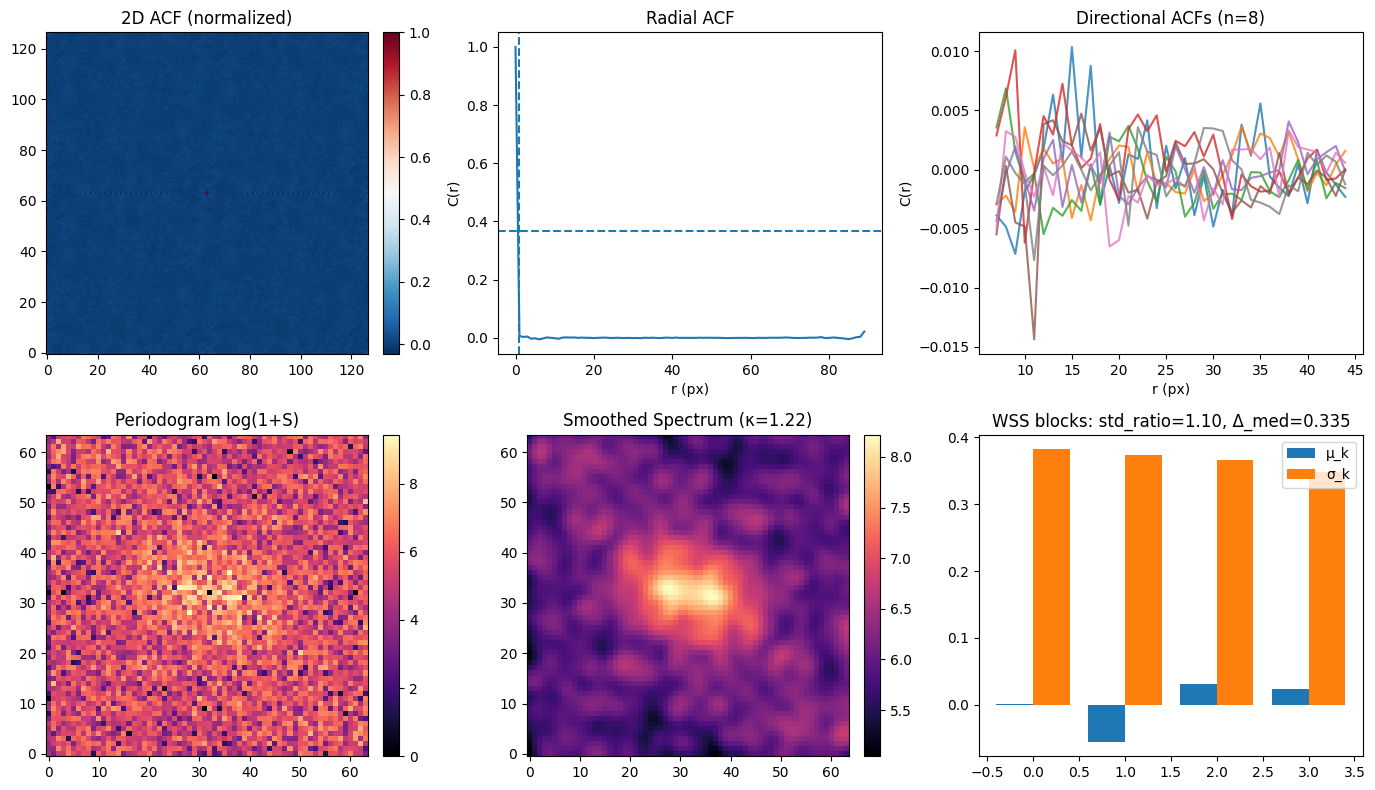

【决策】 LOCAL_ANALYSIS
说明： 存在非平稳性（分块统计或分块ACF差异明显），尽管各向同性近似尚可。建议去趋势/局部标准化后做**局部**ACF/谱分析，或报告不同区域的径向曲线。


In [22]:
results = spatial_correlation_diagnostics(noise0, 
                                          average_frames=10, 
                                          blocks=(2,2), 
                                          n_angles=8, 
                                          r_max=None, 
                                          show_plots=True)

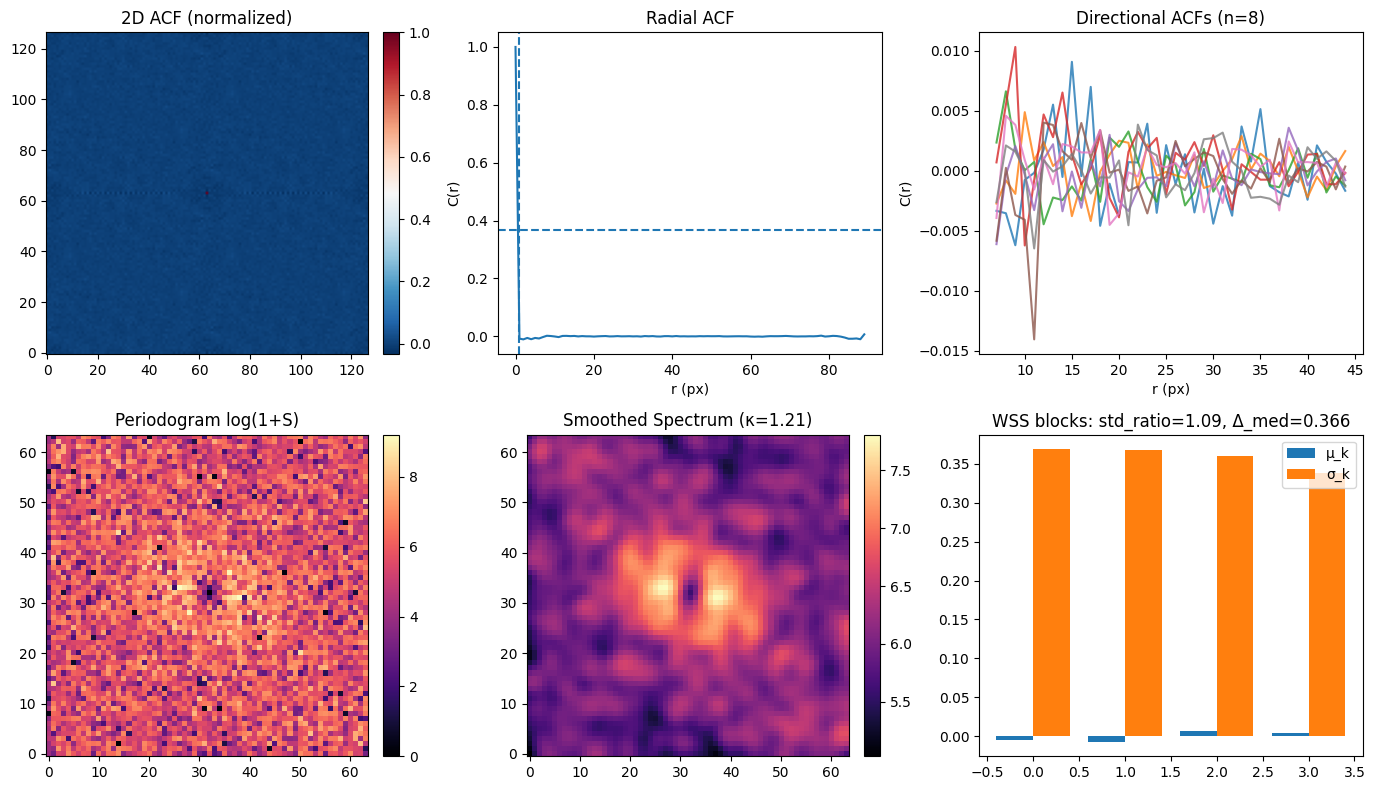

【决策】 LOCAL_ANALYSIS
说明： 存在非平稳性（分块统计或分块ACF差异明显），尽管各向同性近似尚可。建议去趋势/局部标准化后做**局部**ACF/谱分析，或报告不同区域的径向曲线。


In [23]:
results_local = spatial_correlation_diagnostics(noise0,
    average_frames=10,
    use_local_standardize=True,
    show_plots=True
)


放弃全局分析，转为局部

In [24]:
def _spectrum_kappa(img, smooth_sigma=1.5):
    F = img - img.mean()
    S = np.abs(np.fft.fftshift(np.fft.fft2(F)))**2
    if smooth_sigma and smooth_sigma > 0:
        Ssm = gaussian_filter(S, sigma=smooth_sigma)
    else:
        Ssm = S
    X, Y = Ssm.shape
    fy = np.linspace(-1, 1, X); fx = np.linspace(-1, 1, Y)
    FY, FX = np.meshgrid(fy, fx, indexing='ij')
    Mxx = np.sum((FX**2) * Ssm); Myy = np.sum((FY**2) * Ssm); Mxy = np.sum((FX*FY) * Ssm)
    evals = np.linalg.eigvalsh(np.array([[Mxx, Mxy],[Mxy, Myy]]))
    lam_min, lam_max = evals[0], evals[-1]
    kappa = lam_max / (lam_min + 1e-12)
    return S, Ssm, float(kappa)

def spatial_correlation_local_report(field,
                                     average_frames=10,
                                     blocks=(2,2),
                                     use_local_standardize=True,
                                     n_angles=8,
                                     r_max=None,
                                     show_plots=True):
    """
    对每个子块计算：2D ACF、径向ACF、相关长度 xi、方向离散度 D_k、谱椭圆率 kappa_k。
    产出：xi 热力图、分块径向曲线面板、分块谱图面板（可选）。
    """
    T, X, Y = field.shape
    K = min(average_frames, T)
    frames0 = field[:K].astype(np.float64)
    frames = _detrend_and_standardize(frames0, local=use_local_standardize)

    # 平均帧（更稳）：频域/展示
    mean_img = frames.mean(axis=0)

    # 分块
    regions = _subblocks_indices(X, Y, blocks)
    bx, by = blocks
    nb = len(regions)

    # 每块计算
    xi_map = np.full((bx, by), np.nan, dtype=float)
    D_list, kappa_map = np.full((bx, by), np.nan), np.full((bx, by), np.nan)
    radials = []    # 保存每块的径向曲线
    acf2ds = []     # 如需展示
    spectra = []    # 如需展示

    for idx, (sx, sy) in enumerate(regions):
        bi, bj = divmod(idx, by)
        # 用每帧的该子块，做 ACF 平均
        acf2d = np.zeros((2*(sx.stop - sx.start)-1, 2*(sy.stop - sy.start)-1), dtype=np.float64)
        for t in range(K):
            acf2d += _acf2d(frames[t, sx, sy])
        acf2d /= K
        acf2ds.append(acf2d)

        # 径向 + xi
        radial = _radial_average(acf2d, r_max=r_max)
        radials.append(radial)
        xi = int(np.argmax(radial < np.exp(-1))) if np.any(radial < np.exp(-1)) else np.nan
        xi_map[bi, bj] = xi

        # 方向离散度（各向同性的局部证据）
        prof = _directional_profiles(acf2d, n_angles=n_angles, r_max=(len(radial)-1))
        R = prof.shape[1]; r_lo, r_hi = max(1, R//12), max(2, R//2)
        D_r = np.var(prof[:, r_lo:r_hi], axis=0)
        D_med = float(np.median(D_r))
        D_list[bi, bj] = D_med

        # 谱椭圆率（方向性频域证据）
        S, Ssm, kappa = _spectrum_kappa(mean_img[sx, sy], smooth_sigma=1.2)
        spectra.append(Ssm)
        kappa_map[bi, bj] = kappa

    results = dict(
        blocks=blocks,
        xi_map=xi_map,
        D_map=D_list,
        kappa_map=kappa_map,
        radials=radials,
        acf2ds=acf2ds,
        spectra=spectra,
        meta=dict(average_frames=K, n_angles=n_angles, use_local_standardize=use_local_standardize)
    )

    if show_plots:
        # 1) 相关长度热力图
        fig, ax = plt.subplots(1, 3, figsize=(14,4))
        im0 = ax[0].imshow(xi_map, cmap='viridis', origin='lower')
        ax[0].set_title("Local correlation length ξ (pixels)")
        plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

        im1 = ax[1].imshow(D_list, cmap='magma', origin='lower')
        ax[1].set_title("Directional dispersion D (median over r)")
        plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

        im2 = ax[2].imshow(kappa_map, cmap='cividis', origin='lower', vmin=1.0)
        ax[2].set_title("Spectral anisotropy κ (λ_max/λ_min)")
        plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

        # 2) 分块径向曲线面板
        rows, cols = blocks
        fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), squeeze=False)
        for idx, radial in enumerate(radials):
            r = np.arange(len(radial))
            i, j = divmod(idx, cols)
            axs[i,j].plot(r, radial, lw=1.5)
            axs[i,j].axhline(np.exp(-1), ls='--', alpha=0.6)
            xi = xi_map[i, j]
            if np.isfinite(xi):
                axs[i,j].axvline(int(xi), ls='--', alpha=0.6)
            axs[i,j].set_title(f"Block ({i+1},{j+1})  ξ≈{xi_map[i,j]:.0f}, D≈{D_list[i,j]:.3f}, κ≈{kappa_map[i,j]:.2f}")
            axs[i,j].set_xlabel("r (px)"); axs[i,j].set_ylabel("C(r)")
        plt.tight_layout(); plt.show()

    # 简短文字结论（给你复用在报告里）
    print("—— 局部分析小结 ——")
    print(f"分块: {blocks}, 帧数用于平均: {K}, 局部标准化: {use_local_standardize}")
    print(f"ξ（相关长度）范围: [{np.nanmin(xi_map):.0f}, {np.nanmax(xi_map):.0f}] px")
    print(f"D（方向离散度）中位数: {np.nanmedian(D_list):.3f}（越小越各向同性）")
    print(f"κ（谱椭圆率）范围: [{np.nanmin(kappa_map):.2f}, {np.nanmax(kappa_map):.2f}]（≈1为圆对称）")

    return results

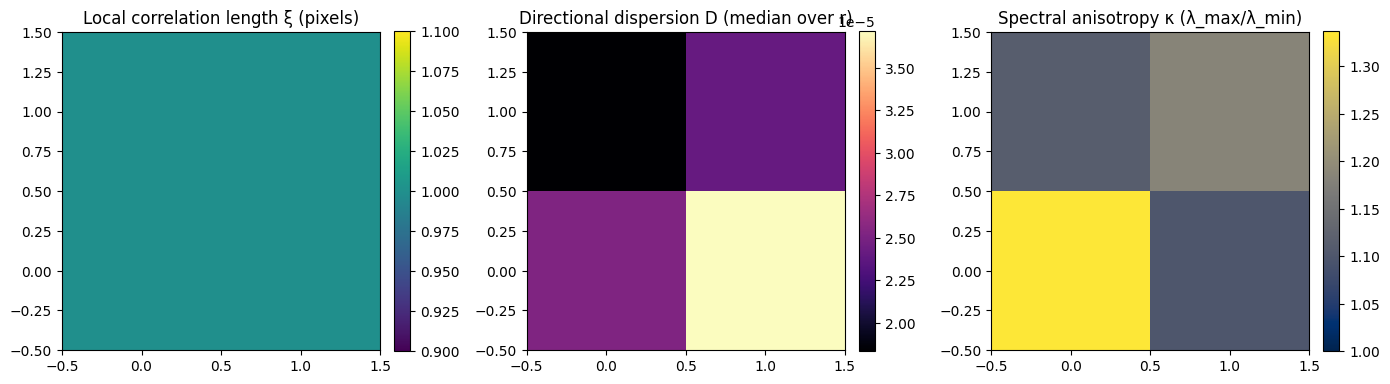

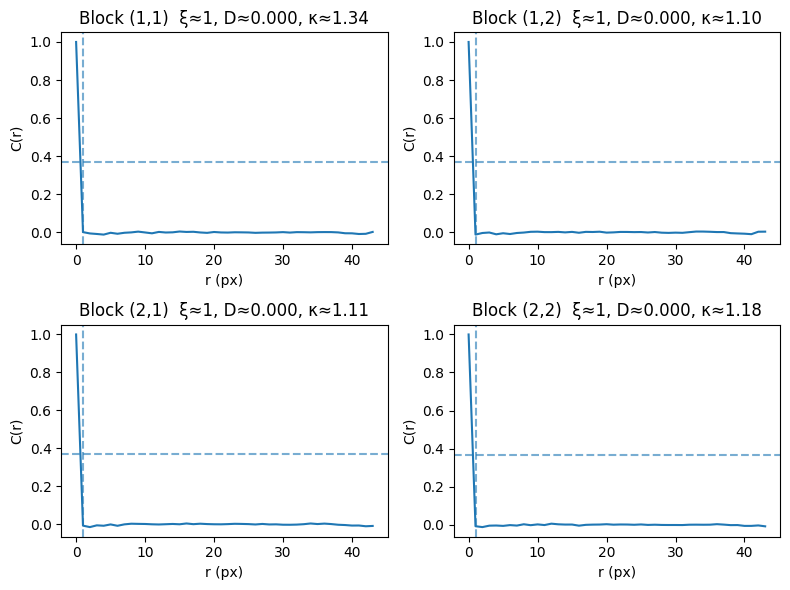

—— 局部分析小结 ——
分块: (2, 2), 帧数用于平均: 10, 局部标准化: True
ξ（相关长度）范围: [1, 1] px
D（方向离散度）中位数: 0.000（越小越各向同性）
κ（谱椭圆率）范围: [1.10, 1.34]（≈1为圆对称）


In [25]:
# 强烈建议：局部标准化以削弱漂移
local_res = spatial_correlation_local_report(
    noise0,
    average_frames=10,
    blocks=(2,2),              # 可改 (3,3) / (4,4) 看空间分辨率需要
    use_local_standardize=True,
    n_angles=8,
    r_max=None,
    show_plots=True
)


成功在所有假设下证明像素之间没有线性相关！

In [3]:
# -*- coding: utf-8 -*-
# Optimized HSIC (RBF kernel) — PyTorch version with caching + robust bandwidth + vectorized radial mean

import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================
# Global dtype (configurable)
# ==========================
DTYPE = torch.float64  # you can switch to torch.float32 in hsic_map_rbf_torch(..., dtype=torch.float32)

# ==========================
# Caches
# ==========================
_H_CACHE: dict[tuple, Tensor] = {}          # key: (n, dtype, device) -> H
_GRID_CACHE: dict[tuple, tuple] = {}        # key: (H, W, device) -> (yy, xx, r_long, rmax)
_SIGMA_CACHE: dict[tuple, Tensor] = {}      # optional: (n, device, dtype, 'x'/'y') -> sigma (if you want to cache computed sigmas)


# -----------------------------------------
# 1) Sampling pairs (unchanged, already OK)
# -----------------------------------------
@torch.no_grad()
def sample_pairs_for_shift_torch(field: Tensor, dx: int, dy: int,
                                 max_samples: int = 3000, spatial_stride: int = 1,
                                 generator=None) -> tuple[Tensor, Tensor]:
    """
    Sample pixel pairs separated by spatial shift (dx, dy) from a 3D field (T, X, Y).
    Returns flattened 1D tensors (xvals, yvals). If total pairs > max_samples, random subsample.
    """
    T, X, Y = field.shape
    xs = torch.arange(0, X, spatial_stride, device=field.device)
    ys = torch.arange(0, Y, spatial_stride, device=field.device)

    a = field[:, xs, :][:, :, ys]  # (T, |xs|, |ys|)
    b = torch.roll(field, shifts=(0, dx, dy), dims=(0, 1, 2))[:, xs, :][:, :, ys]

    a = a.reshape(-1)
    b = b.reshape(-1)

    n = a.numel()
    if n > max_samples:
        gen = generator or torch.Generator(device=field.device)
        idx = torch.randperm(n, generator=gen, device=field.device)[:max_samples]
        a = a[idx]
        b = b[idx]
    return a, b


# ------------------------------------------------------
# 2) Vectorized radial mean with cached grid / binning
# ------------------------------------------------------
@torch.no_grad()
def radial_mean_from_map_torch(arr2d: Tensor) -> tuple[Tensor, tuple[int, int]]:
    """
    Compute radial mean curve from a 2D map centered at (cx, cy).
    Uses cached (yy, xx, r) grid and vectorized binning, ignoring NaNs.
    Returns (radial_mean, (cx, cy)).
    """
    Hh, Ww = arr2d.shape
    cx, cy = Hh // 2, Ww // 2
    key = (Hh, Ww, arr2d.device)

    # cache (yy, xx, r_long)
    if key not in _GRID_CACHE:
        yy, xx = torch.meshgrid(
            torch.arange(Hh, device=arr2d.device),
            torch.arange(Ww, device=arr2d.device),
            indexing="ij"
        )
        r = torch.sqrt((yy - cx).to(DTYPE) ** 2 + (xx - cy).to(DTYPE) ** 2)
        r_long = r.long()
        rmax = int(r_long.max())
        _GRID_CACHE[key] = (yy, xx, r_long, rmax)
    else:
        yy, xx, r_long, rmax = _GRID_CACHE[key]

    # flatten and ignore NaNs
    vals = arr2d.reshape(-1)
    rflat = r_long.reshape(-1)
    finite_mask = torch.isfinite(vals)
    if not finite_mask.any():
        radial = torch.full((int(rflat.max().item()) + 1,), float("nan"), dtype=DTYPE, device=arr2d.device)
        return radial, (cx, cy)

    vals = vals[finite_mask].to(DTYPE)
    bins = rflat[finite_mask]

    # sum and count per radius via bincount (vectorized)
    # NOTE: torch.bincount supports with weights; counts are integer bincount
    rmax_eff = int(bins.max().item())
    sums = torch.bincount(bins, weights=vals, minlength=rmax_eff + 1).to(DTYPE)
    cnts = torch.bincount(bins, minlength=rmax_eff + 1).to(DTYPE)

    # avoid division by zero
    radial = torch.full((rmax_eff + 1,), float("nan"), dtype=DTYPE, device=arr2d.device)
    nz = cnts > 0
    radial[nz] = sums[nz] / cnts[nz]
    return radial, (cx, cy)


# ------------------------------------------------------
# 3) HSIC with robust bandwidth + optional no-H centering
# ------------------------------------------------------
def _get_centering_H(n: int, dtype: torch.dtype, device: torch.device) -> Tensor:
    """Get (and cache) the centering matrix H = I - 11^T/n of size n."""
    key = (n, dtype, device)
    H = _H_CACHE.get(key, None)
    if H is None:
        I = torch.eye(n, dtype=dtype, device=device)
        O = torch.ones((n, n), dtype=dtype, device=device) / n
        H = I - O
        _H_CACHE[key] = H
    return H


@torch.no_grad()
def _center_kernel_mean(K: Tensor) -> Tensor:
    """
    Center a Gram matrix without explicit H, using mean subtraction:
      Kc = K - row_mean - col_mean + grand_mean
    This is algebraically equivalent to H K H but saves one large matrix alloc.
    """
    row_mean = K.mean(dim=1, keepdim=True)
    col_mean = K.mean(dim=0, keepdim=True)
    grand_mean = K.mean()
    Kc = K - row_mean - col_mean + grand_mean
    return Kc


@torch.no_grad()
def _rbf_gram(vec: Tensor, sigma: Tensor | float | None) -> Tensor:
    """
    Construct RBF Gram matrix K with robust bandwidth handling.
    vec: shape (n,) or (n,1)
    sigma: if None -> median heuristic; if float/Tensor -> use as bandwidth.
    """
    v = vec.view(-1, 1)
    # pairwise squared Euclidean
    d2 = torch.cdist(v, v, p=2) ** 2

    if sigma is None:
        # median heuristic with robust fallback
        # pick strictly positive distances to avoid zeros on diagonal
        mask = d2 > 0
        if mask.any():
            m = torch.median(d2[mask])
            if torch.isfinite(m) and (m > 0):
                s = torch.sqrt(0.5 * m)
            else:
                # fallback: use 0.5 * quantile(0.5) if finite, else 1.0
                q = torch.quantile(d2[mask], 0.5)
                s = torch.sqrt(0.5 * q) if torch.isfinite(q) and (q > 0) else torch.tensor(1.0, device=v.device, dtype=v.dtype)
        else:
            # all distances zero → constant data; degenerate case
            s = torch.tensor(1.0, device=v.device, dtype=v.dtype)
    else:
        s = torch.as_tensor(sigma, device=v.device, dtype=v.dtype)

    K = torch.exp(-d2 / (2 * s ** 2))
    return K


@torch.no_grad()
def hsic_stat_torch(x: Tensor,
                    y: Tensor,
                    sigma_x: float | Tensor | None = None,
                    sigma_y: float | Tensor | None = None,
                    use_explicit_H: bool = False,
                    dtype: torch.dtype | None = None) -> Tensor:
    """
    Biased HSIC estimator with options:
      - robust bandwidth (median heuristic with fallback) unless sigma_* provided
      - centering without explicitly forming H (default), or with cached H (optional)
      - configurable dtype

    HSIC_biased = trace(Kc Lc) / (n-1)^2
    where Kc = H K H or K - rowmean - colmean + grand_mean.
    """
    dt = dtype or DTYPE
    x = x.to(dt)
    y = y.to(dt)
    n = x.numel()

    # construct Gram matrices with robust sigma
    Kx = _rbf_gram(x, sigma_x)
    Ky = _rbf_gram(y, sigma_y)

    if use_explicit_H:
        H = _get_centering_H(n, dt, x.device)
        Kc = H @ Kx @ H
        Lc = H @ Ky @ H
    else:
        Kc = _center_kernel_mean(Kx)
        Lc = _center_kernel_mean(Ky)

    # trace(Kc Lc) / (n-1)^2
    HSIC = torch.trace(Kc @ Lc) / ((n - 1) ** 2)
    return HSIC


# ------------------------------------------------------
# 4) HSIC map with options (dtype, per-frame std, fixed sigma)
# ------------------------------------------------------
@torch.no_grad()
def hsic_map_rbf_torch(field: Tensor,
                       max_shift: int = 15,
                       average_frames: int | None = None,
                       radial: bool = True,
                       max_samples: int = 3000,
                       spatial_stride: int = 1,
                       device: str = "cuda",
                       seed: int = 0,
                       show_progress: bool = True,
                       dtype: torch.dtype | None = None,
                       per_frame_standardize: bool = False,
                       sigma_x: float | Tensor | None = None,
                       sigma_y: float | Tensor | None = None,
                       use_explicit_H: bool = False):
    """
    Compute HSIC map over spatial shifts.

    Parameters (new / key)
    ----------------------
    dtype : torch.dtype or None
        Compute dtype (default uses global DTYPE).
    per_frame_standardize : bool
        If True, subtract per-frame mean and divide per-frame std (robust to temporal drift).
    sigma_x, sigma_y : float/Tensor/None
        If provided, use fixed bandwidths for RBF on X and Y; otherwise use robust median heuristic.
    use_explicit_H : bool
        If True, center with Kc = H K H using cached H; by default use mean-centering (no explicit H).

    Returns
    -------
    hsic_map : np.ndarray
    radial_mean : np.ndarray | None
    """
    dt = dtype or DTYPE
    if not torch.is_tensor(field):
        field = torch.as_tensor(field, dtype=dt)
    else:
        field = field.to(dtype=dt)

    # move to device
    field = field.to(device)

    gen = torch.Generator(device=device)
    gen.manual_seed(seed)

    # optional temporal averaging
    if average_frames is not None:
        field = field[:average_frames]

    # standardization
    if per_frame_standardize:
        # per-frame mean/std: shape (T,1,1)
        mu = field.mean(dim=(1, 2), keepdim=True)
        std = field.std(dim=(1, 2), keepdim=True)
        std = torch.where(std > 0, std, torch.ones_like(std))
        field = (field - mu) / std
    else:
        # global mean-only removal (your original behavior)
        field = field - field.mean()

    shifts = range(-max_shift, max_shift + 1)
    size = 2 * max_shift + 1
    hsic_map = torch.full((size, size), float("nan"), dtype=dt, device=device)

    iterator = tqdm(shifts, desc="HSIC shifts", ncols=90, disable=not show_progress)
    for i, dx in enumerate(iterator):
        for j, dy in enumerate(shifts):
            if dx == 0 and dy == 0:
                continue
            xvals, yvals = sample_pairs_for_shift_torch(
                field, dx, dy, max_samples=max_samples,
                spatial_stride=spatial_stride, generator=gen
            )
            hsic_map[i, j] = hsic_stat_torch(
                xvals, yvals,
                sigma_x=sigma_x, sigma_y=sigma_y,
                use_explicit_H=use_explicit_H,
                dtype=dt
            )

    radial_mean = None
    if radial:
        radial_mean, _ = radial_mean_from_map_torch(hsic_map)

    # move back to CPU/np for plotting
    return hsic_map.detach().cpu().numpy(), (None if radial_mean is None else radial_mean.detach().cpu().numpy())


# ------------------------------------------------------
# 5) Nonlinear correlation length + plotting (unchanged)
# ------------------------------------------------------
def nonlinear_corr_length_from_hsic(radial_curve: np.ndarray):
    if radial_curve is None or not np.isfinite(radial_curve).any():
        return None
    base = np.nanmean(radial_curve[1:4]) if radial_curve.size > 4 else np.nanmean(radial_curve[1:])
    # guard base
    if not np.isfinite(base) or base <= 0:
        return None
    thr = 0.05 * base
    idx = np.where(radial_curve < thr)[0]
    return int(idx[0]) if idx.size > 0 else None


def plot_hsic_radials(radials,
                      labels=None,
                      normalize="first_band",
                      xlim=None,
                      ylim=None,
                      title="HSIC radial curves (block-wise)",
                      figsize=(6, 4),
                      smooth=None):
    """
    Plot radial HSIC curves explicitly (e.g., one curve per block).
    """
    if labels is None:
        labels = [f"block {k}" for k in range(len(radials))]

    def _ma(arr, w):
        if w is None or w < 3:
            return arr
        w = int(w)
        if w % 2 == 0:
            w += 1
        pad = w // 2
        padv = np.pad(arr, (pad, pad), mode="edge")
        ker = np.ones(w, dtype=float) / w
        return np.convolve(padv, ker, mode="valid")

    def _normalize(arr):
        if arr is None or not np.isfinite(arr).any():
            return arr
        if normalize == "none":
            return arr
        if normalize == "max":
            m = np.nanmax(arr)
            return arr / m if np.isfinite(m) and m != 0 else arr
        if normalize == "first_band":
            if arr.size > 4:
                base = np.nanmean(arr[1:4])
            else:
                base = np.nanmean(arr[1:]) if arr.size > 1 else np.nanmean(arr)
            return arr / base if np.isfinite(base) and base != 0 else arr
        return arr

    fig, ax = plt.subplots(figsize=figsize)
    for r, lab in zip(radials, labels):
        rr = r
        if rr is None:
            continue
        rr = _normalize(rr)
        rr = _ma(rr, smooth)
        ax.plot(rr, label=lab)

    ax.set_xlabel("radius r (pixels)")
    ax.set_ylabel("HSIC (normalized)" if normalize != "none" else "HSIC")
    ax.set_title(title)
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    if labels is not None:
        ax.legend()
    ax.grid(True, alpha=0.3)
    return fig, ax


# ------------------------------------------------------
# 6) Block-wise HSIC (compatible; passes options through)
# ------------------------------------------------------
def hsic_blockwise(field,
                   blocks=(2, 2),
                   max_shift=15,
                   average_frames=None,
                   radial=True,
                   max_samples=3000,
                   spatial_stride=1,
                   device=None,
                   seed=0,
                   show_progress=False,
                   dtype: torch.dtype | None = None,
                   per_frame_standardize: bool = False,
                   sigma_x: float | Tensor | None = None,
                   sigma_y: float | Tensor | None = None,
                   use_explicit_H: bool = False):
    """
    Compute HSIC maps and radial curves per spatial block (locally stationary assumption).
    New options are forwarded to hsic_map_rbf_torch for consistency.
    """
    # resolve device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # ensure tensor
    dt = dtype or DTYPE
    if not torch.is_tensor(field):
        field_t = torch.as_tensor(field, dtype=dt)
    else:
        field_t = field.to(dtype=dt)

    if field_t.ndim != 3:
        raise ValueError("`field` must be a 3D array / tensor with shape (T, X, Y).")
    T, X, Y = field_t.shape

    # reuse your subblocks indexer (assumed already defined in your codebase)
    regions = _subblocks_indices(X, Y, blocks=blocks)

    results = {
        "blocks": blocks,
        "per_block": []
    }

    b = 0
    for i in range(blocks[0]):
        for j in range(blocks[1]):
            xs, ys = regions[b]
            b += 1

            sub = field_t[:, xs, ys]
            hsic_map, hsic_r = hsic_map_rbf_torch(
                sub,
                max_shift=max_shift,
                average_frames=average_frames,
                radial=radial,
                max_samples=max_samples,
                spatial_stride=spatial_stride,
                device=device,
                show_progress=show_progress,
                seed=seed,
                dtype=dt,
                per_frame_standardize=per_frame_standardize,
                sigma_x=sigma_x,
                sigma_y=sigma_y,
                use_explicit_H=use_explicit_H
            )

            xi_nl = nonlinear_corr_length_from_hsic(hsic_r)

            results["per_block"].append({
                "block_index": (i, j),
                "xslice": xs,
                "yslice": ys,
                "hsic_map": hsic_map,
                "radial": hsic_r,
                "xi_nl": xi_nl
            })

    return results


HSIC shifts: 100%|████████████████████████████████████████| 31/31 [04:48<00:00,  9.30s/it]


Global nonlinear correlation length ξ_nl ≈ None


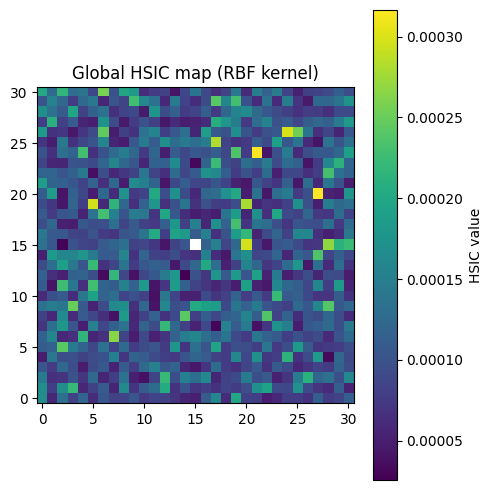

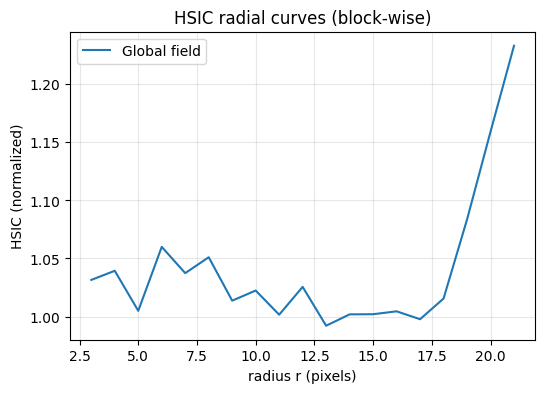

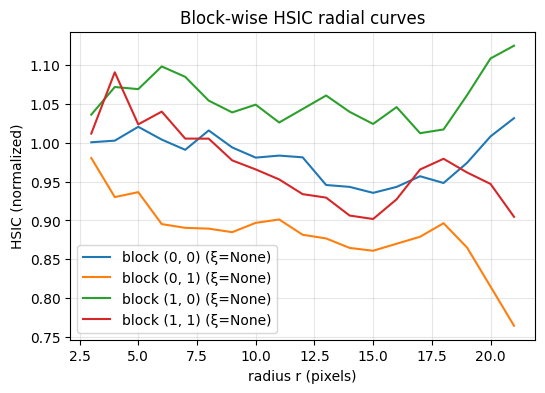

In [7]:
noise0 = torch.as_tensor(noise0, dtype=DTYPE)  # (T, 64, 64)
# ---------- 1) 全局 HSIC ----------
hsic_map, hsic_r = hsic_map_rbf_torch(
    noise0,
    max_shift=15,
    average_frames=10,
    radial=True,
    max_samples=3000,
    spatial_stride=2,
    device="cuda" if torch.cuda.is_available() else "cpu",
    per_frame_standardize=True,     # 每帧标准化 (optional)
    show_progress=True
)

xi_global = nonlinear_corr_length_from_hsic(hsic_r)
print(f"Global nonlinear correlation length ξ_nl ≈ {xi_global}")

# --- 可视化 ---
plt.figure(figsize=(5, 5))
plt.imshow(hsic_map, cmap="viridis", origin="lower")
plt.colorbar(label="HSIC value")
plt.title("Global HSIC map (RBF kernel)")
plt.tight_layout()
plt.show()

# 使用你写好的函数绘制径向曲线
plot_hsic_radials([hsic_r], labels=["Global field"], normalize="first_band", smooth=5)
plt.show()


# ---------- 2) 分块 HSIC ----------
results = hsic_blockwise(
    noise0,
    blocks=(2, 2),                  # 2x2 blocks
    max_shift=15,
    average_frames=10,
    radial=True,
    max_samples=3000,
    spatial_stride=2,
    device="cuda" if torch.cuda.is_available() else "cpu",
    per_frame_standardize=True,
    show_progress=False
)

# 提取径向曲线与 block 标签
radials = [b["radial"] for b in results["per_block"]]
labels = [f"block {b['block_index']} (ξ={b['xi_nl']})" for b in results["per_block"]]

# --- 使用同一个绘图函数绘制多条径向曲线 ---
plot_hsic_radials(radials, labels=labels, normalize="first_band", smooth=5)
plt.title("Block-wise HSIC radial curves")
plt.show()


像素的统计特征：

符合多元高斯分布

像素间无线性或非线性correlation

现在研究帧与帧之间的correlation, 其实更像是时间上的correlation.

我们现在获得思路可以通过DL来拟合非线性相关，但是统计假设的验证还是要做一些的帮助我们理解数据

在应用DL 模型之前我们还是要验证一些个统计特性：

(1) 时间WSS二阶平稳：去趋势后，均值与方差不随时间变；协方差只依赖时滞h。

(2) 空间同质的时间规律：同一组“时间相关函数”在不同像素（或子块）基本一致（允许小噪声/尺度差）。

In [12]:
# Improved temporal correlation diagnostics with normalized distance and block-bootstrap CIs
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Optional

def rolling_mean_1d(arr: np.ndarray, window: int) -> np.ndarray:
    """Centered moving average with reflect padding."""
    if window <= 1:
        return arr.astype(np.float64, copy=True)
    w = int(window)
    if w % 2 == 0:
        w += 1
    pad = w // 2
    arr = np.asarray(arr, dtype=np.float64)
    padv = np.pad(arr, (pad, pad), mode="reflect")
    ker = np.ones(w, dtype=float) / w
    out = np.convolve(padv, ker, mode="valid")
    return out

def temporal_detrend_per_pixel(field: np.ndarray, window: int = 7) -> np.ndarray:
    """Detrend each pixel over time by subtracting a moving average.
    field: (T, X, Y)
    """
    T, X, Y = field.shape
    out = np.empty_like(field, dtype=np.float64)
    for i in range(X):
        for j in range(Y):
            series = field[:, i, j].astype(np.float64)
            trend = rolling_mean_1d(series, window=window)
            out[:, i, j] = series - trend
    return out

def acf_1d(x: np.ndarray, max_lag: int) -> np.ndarray:
    """Biased ACF normalized to 1 at lag 0. Returns shape (max_lag+1,)"""
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    var = np.dot(x, x) / len(x)
    if var <= 0 or len(x) == 0:
        return np.zeros(max_lag + 1, dtype=np.float64)
    ac = np.correlate(x, x, mode="full")
    mid = len(ac) // 2
    ac = ac[mid: mid + max_lag + 1] / (len(x) * var)
    return ac

def block_slices(X: int, Y: int, blocks: Tuple[int, int]) -> List[Tuple[slice, slice]]:
    bx, by = blocks
    xs = np.linspace(0, X, bx + 1, dtype=int)
    ys = np.linspace(0, Y, by + 1, dtype=int)
    regions = []
    for i in range(bx):
        for j in range(by):
            regions.append((slice(xs[i], xs[i+1]), slice(ys[j], ys[j+1])))
    return regions

def _circular_block_bootstrap_1d(y: np.ndarray, L: int, B: int) -> np.ndarray:
    """Return bootstrap resamples as a 2D array (B, T) using circular block bootstrap.
    y shape: (T,)
    """
    y = np.asarray(y, dtype=np.float64)
    T = len(y)
    if T == 0:
        return np.empty((B, 0), dtype=np.float64)
    if L <= 1:
        # ordinary bootstrap on indices (less ideal for time series but fallback)
        idx = np.random.randint(0, T, size=(B, T))
        return y[idx]
    # wrap for circular indexing
    y_wrap = np.concatenate([y, y[:L-1]])
    n_blocks = int(np.ceil(T / L))
    out = np.empty((B, T), dtype=np.float64)
    for b in range(B):
        pieces = []
        for _ in range(n_blocks):
            start = np.random.randint(0, T)  # start anywhere
            pieces.append(y_wrap[start:start+L])
        boot = np.concatenate(pieces)[:T]
        out[b] = boot
    return out

def _pairwise_acf_similarity(acf_blocks: np.ndarray, drop_lag0: bool=True) -> Tuple[np.ndarray, np.ndarray]:
    """Compute pairwise shape distances/correlations between block ACF curves.
    Distance is 1 - Pearson correlation on centered ACF vectors (scale-invariant).
    Returns:
      dists: 1 - corr per pair
      cors: Pearson correlation per pair
    """
    B, L = acf_blocks.shape
    start = 1 if drop_lag0 else 0
    curves = acf_blocks[:, start:]
    # center each curve to remove scale/offset
    curves = curves - curves.mean(axis=1, keepdims=True)
    # compute pairwise correlations
    idx_i, idx_j = np.triu_indices(B, k=1)
    dists = []
    cors = []
    for i, j in zip(idx_i, idx_j):
        a = curves[i]; b = curves[j]
        denom = np.sqrt(np.dot(a,a) * np.dot(b,b)) + 1e-12
        c = float(np.dot(a,b) / denom)
        cors.append(c)
        dists.append(1.0 - c)
    return np.array(dists, dtype=np.float64), np.array(cors, dtype=np.float64)


def _circular_block_indices(T: int, L: int) -> np.ndarray:
    if L <= 1:
        return np.random.randint(0, T, size=T)
    y_idx = np.arange(T)
    wrap = np.concatenate([y_idx, y_idx[:L-1]])
    n_blocks = int(np.ceil(T / L))
    blocks = []
    for _ in range(n_blocks):
        start = np.random.randint(0, T)
        blocks.append(wrap[start:start+L])
    idx = np.concatenate(blocks)[:T]
    return idx

def _default_block_len(T: int, acf_global: np.ndarray) -> int:

    # Integrated autocorrelation time (positive tail)
    vals = acf_global[1:]
    pos = vals[vals>0]
    iat = 1.0 + 2.0 * np.sum(pos) if pos.size>0 else 1.0
    L_iat = int(round(iat))
    L_cube = int(round(T**(1/3)))  # Politis-White heuristic scale
    L = max(8, min(64, max(L_iat, L_cube)))  # clamp to [8, 64]
    return L
def temporal_stationarity_diagnostics(
    field: np.ndarray,
    max_lag: int = 50,
    blocks: Tuple[int, int] = (2, 2),
    detrend: bool = True,
    trend_window: int = 7,
    local_standardize: bool = False,
    thresholds: Optional[Dict[str, float]] = None,
    # Bootstrap options
    do_bootstrap: bool = True,
    B: int = 1000,
    block_len: Optional[int] = None,
    ci_level: float = 0.95,
) -> Dict[str, object]:
    """Diagnose temporal WSS and homogeneity of temporal correlation across subspaces.
    Adds normalized ACF distance (1 - corr) and circular block-bootstrap CIs.
    Returns dict with metrics and (if enabled) CIs.
    """
    if thresholds is None:
        thresholds = dict(
            mu_cv_max=0.1,
            sigma_ratio_max=1.5,
            # new distance is 1 - corr median (scale/offset invariant)
            acf_dist_median_max=0.15,   # ~ corr_median >= 0.85
            acf_corr_median_min=0.85
        )

    assert field.ndim == 3, "`field` must be (T, X, Y)"
    T, X, Y = field.shape
    F = field.astype(np.float64, copy=False)

    if detrend:
        F = temporal_detrend_per_pixel(F, window=trend_window)

    if local_standardize:
        mu_t = F.mean(axis=(1,2), keepdims=True)
        sd_t = F.std(axis=(1,2), keepdims=True)
        sd_t[sd_t == 0] = 1.0
        F = (F - mu_t) / sd_t

    # A1: mean/variance stability
    mu_t = F.mean(axis=(1,2))
    sigma_t = F.std(axis=(1,2)) + 1e-12
    mu_cv = float(np.std(mu_t) / (np.std(F) + 1e-12))
    sigma_ratio = float(np.max(sigma_t) / max(np.min(sigma_t), 1e-12))

    # global series ACF for visualization
    global_series = F.mean(axis=(1,2))
    acf_global = acf_1d(global_series, max_lag=max_lag)

    # A2: block-wise ACFs
    regs = block_slices(X, Y, blocks)
    acf_blocks = []
    series_blocks = []  # keep for bootstrap
    for sx, sy in regs:
        block_series = F[:, sx, sy].mean(axis=(1,2))
        series_blocks.append(block_series)
        acf_blocks.append(acf_1d(block_series, max_lag=max_lag))
    acf_blocks = np.stack(acf_blocks, axis=0)  # (B, L+1)
    Bblocks = acf_blocks.shape[0]

    # normalized, scale-invariant distance: 1 - corr on centered curves
    dists, cors = _pairwise_acf_similarity(acf_blocks, drop_lag0=True)
    dist_median = float(np.median(dists)) if dists.size else 0.0
    corr_median = float(np.median(cors)) if cors.size else 1.0

    th = thresholds
    A1_ok = (mu_cv <= th["mu_cv_max"]) and (sigma_ratio <= th["sigma_ratio_max"])
    A2_ok = (dist_median <= th["acf_dist_median_max"]) and (corr_median >= th["acf_corr_median_min"])

    if A1_ok and A2_ok:
        decision = "GLOBAL_TEMPORAL_OK"
        note = "时间二阶平稳且子空间间的时间相关形状一致；可用全局共享的时间模型。"
    elif A1_ok and not A2_ok:
        decision = "LOCAL_TEMPORAL_ONLY"
        note = "时间近似平稳，但不同子空间的时间相关形状存在差异；建议局部时间模型或空间自适应时间核。"
    elif (not A1_ok) and A2_ok:
        decision = "DETREND_OR_VARIANCE_STABILIZE"
        note = "时间非平稳（均值/方差随 t 变动），但各子空间时间相关形状相似；需更强去趋势/稳定化。"
    else:
        decision = "NONSTATIONARY_AND_HETEROGENEOUS"
        note = "时间非平稳且子空间时间相关不一致；建议局部+分段时间建模。"

    # ---------- Bootstrap CIs ----------
    ci = {}
    if do_bootstrap:
        # choose block length conservatively
        if block_len is None:
            Lb = _default_block_len(T, acf_global)
        else:
            Lb = int(block_len)

        Bboot = int(B)
        dist_samples = np.empty(Bboot, dtype=np.float64)
        corr_samples = np.empty(Bboot, dtype=np.float64)

        # synchronized circular block bootstrap: same time indices for all subspaces
        for b in range(Bboot):
            idx = _circular_block_indices(T, Lb)
            boot_acfs = []
            for s in series_blocks:
                yb = s[idx]
                boot_acfs.append(acf_1d(yb, max_lag=max_lag))
            boot_acfs = np.stack(boot_acfs, axis=0)
            d_b, c_b = _pairwise_acf_similarity(boot_acfs, drop_lag0=True)
            dist_samples[b] = np.median(d_b) if d_b.size else 0.0
            corr_samples[b] = np.median(c_b) if c_b.size else 1.0

        alpha = 1.0 - float(ci_level)
        lo = 100*alpha/2.0
        hi = 100*(1.0 - alpha/2.0)
        ci["acf_dist_median"] = (float(np.percentile(dist_samples, lo)),
                                 float(np.percentile(dist_samples, hi)))
        ci["acf_corr_median"] = (float(np.percentile(corr_samples, lo)),
                                 float(np.percentile(corr_samples, hi)))
        ci["block_len_used"] = Lb
        ci["B"] = Bboot
        ci["level"] = ci_level
# ---------- Plots (compatible with Matplotlib>=3.8) ----------
# ---------- Plots (compatible with Matplotlib>=3.8) ----------
    # 1) mu_t
    plt.figure()
    plt.plot(mu_t)
    plt.title("μ_t over time (after detrending)" if detrend else "μ_t over time")
    plt.xlabel("t"); plt.ylabel("μ_t"); plt.grid(True, alpha=0.3); plt.tight_layout()

    # 2) sigma_t
    plt.figure()
    plt.plot(sigma_t)
    plt.title("σ_t over time (after detrending)" if detrend else "σ_t over time")
    plt.xlabel("t"); plt.ylabel("σ_t"); plt.grid(True, alpha=0.3); plt.tight_layout()

    # 3) Global ACF
    plt.figure()
    plt.plot(np.arange(len(acf_global)), acf_global, marker="o")
    plt.title("Global temporal ACF (of spatial mean series)")
    plt.xlabel("lag h"); plt.ylabel("ρ(h)"); plt.grid(True, alpha=0.3); plt.tight_layout()

    # 4) Block-wise ACFs
    plt.figure()
    for k in range(Bblocks):
        plt.plot(acf_blocks[k], label=f"block {k+1}")
    plt.title("Block-wise temporal ACFs (spatial means in subspaces)")
    plt.xlabel("lag h"); plt.ylabel("ρ(h)"); plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()

    metrics = dict(
        mu_cv=float(mu_cv),
        sigma_ratio=float(sigma_ratio),
        acf_dist_median=float(dist_median),
        acf_corr_median=float(corr_median),
        A1_time_WSS_ok=bool(A1_ok),
        A2_temporal_homogeneity_ok=bool(A2_ok),
        decision=decision,
        note=note,
        thresholds=thresholds,
    )
    out = dict(
        mu_t=mu_t,
        sigma_t=sigma_t,
        acf_global=acf_global,
        acf_blocks=acf_blocks,
        metrics=metrics,
    )
    if do_bootstrap:
        out["bootstrap"] = ci
    return out



{'mu_cv': 0.0022171853063425754, 'sigma_ratio': 1.2818034200707569, 'acf_dist_median': 0.1759021980616436, 'acf_corr_median': 0.8240978019383565, 'A1_time_WSS_ok': True, 'A2_temporal_homogeneity_ok': False, 'decision': 'LOCAL_TEMPORAL_ONLY', 'note': '时间近似平稳，但不同子空间的时间相关形状存在差异；建议局部时间模型或空间自适应时间核。', 'thresholds': {'mu_cv_max': 0.1, 'sigma_ratio_max': 1.5, 'acf_dist_median_max': 0.15, 'acf_corr_median_min': 0.85}}
{'acf_dist_median': (0.16303275143359747, 0.30675840310920505), 'acf_corr_median': (0.6932415968907949, 0.8369672485664026), 'block_len_used': 10, 'B': 1000, 'level': 0.95}


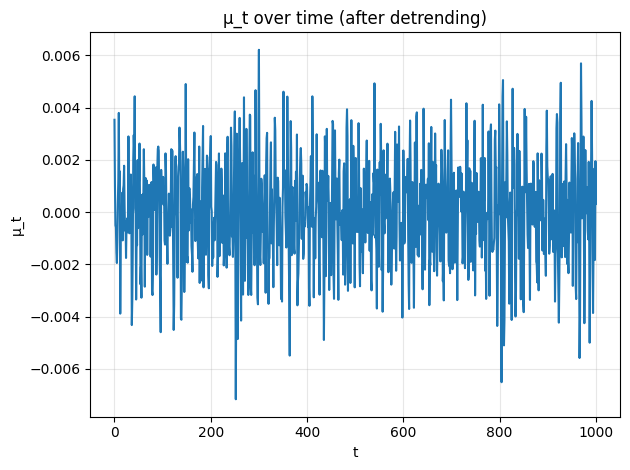

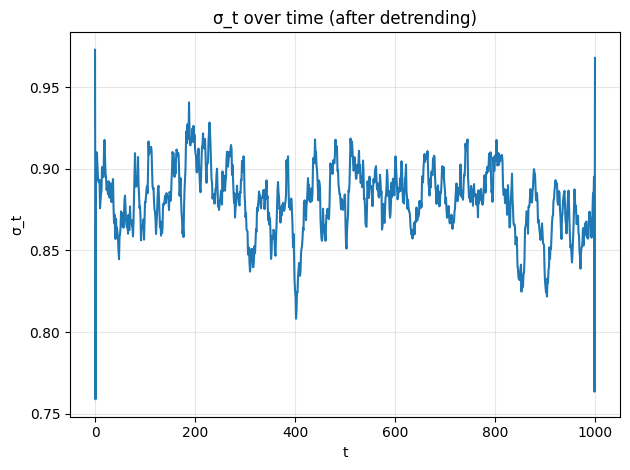

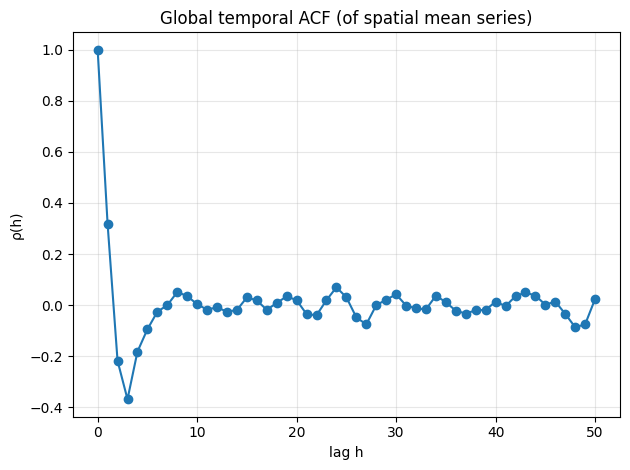

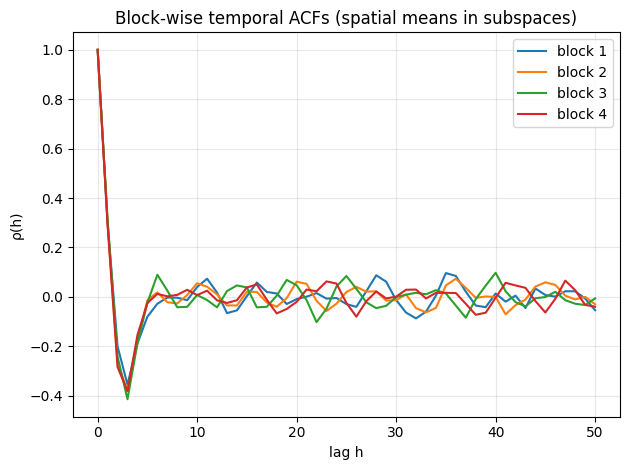

In [13]:
res = temporal_stationarity_diagnostics(
    noise0,
    max_lag=50,
    blocks=(2,2),
    detrend=True,
    trend_window=7,
    local_standardize=False,
    # Bootstrap 相关
    do_bootstrap=True,
    B=1000,          # bootstrap 轮数
    block_len=None,  # 默认自动=IAT（积分自相关时间）的近似
    ci_level=0.95
)

print(res["metrics"])
print(res["bootstrap"])   # 里面有 acf_dist_median 与 acf_corr_median 的 CI


无论是从全局的ACF还是局部的ACF来看，都可以明显地看出来时序线性在某一段时间呈现负相关，之后就是很像是噪声的东西。

现在我们的目标是使用dl模型识别噪声中的时序关系（这也是为什么输入只选择两步的原因），但是为了防止模型拟合之前的负相关我们使用一个AR(2)模型将这段关系模拟出来然后再用原来的数据减掉。 

采用xt, xt-1, xt-2作为输入， 输出为rt = xt - xt_bar(AR2)

我们会不会做的太细了?

Training MLP (predict r_t from past x): 100%|█| 200/200 [00:02<00:00, 83.96it/s]


{'data_source': 'Used provided noise0 with shape (1001, 64, 64)',
 'phi1': 0.980138720123626,
 'phi2': -0.13637985315527626,
 'train_loss_last': 0.9472228288650513,
 'val_loss_last': 1.1510616540908813,
 'acf_x_lag1': 0.8617166729349405,
 'acf_x_lag2': 0.708182804924473,
 'acf_r_lag1': 0.0019194452706180322,
 'acf_r_lag2': -0.0024790454149729397,
 'acf_rhat_lag1': 0.5103556524682953,
 'acf_rhat_lag2': 0.25209369646496677}

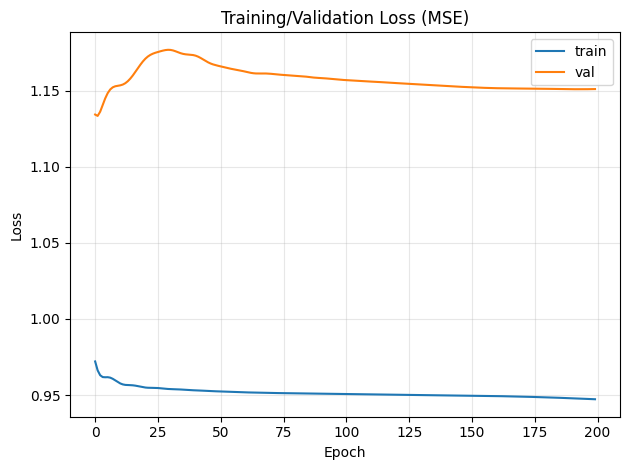

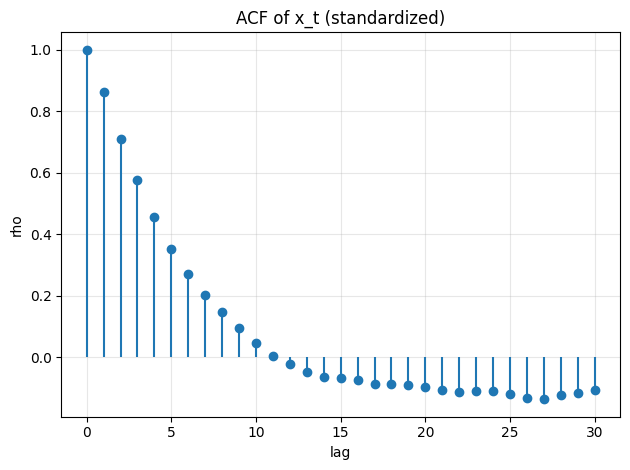

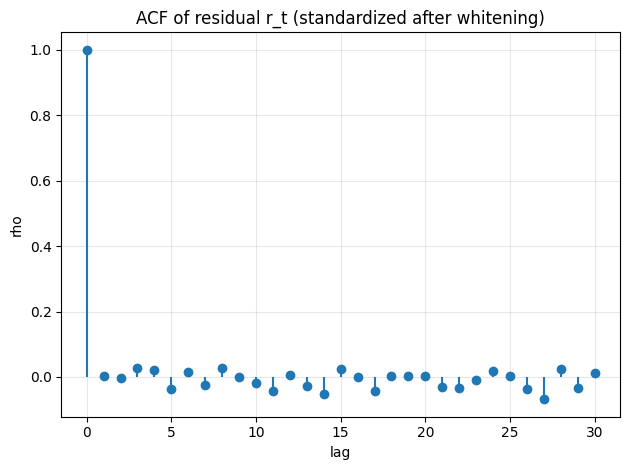

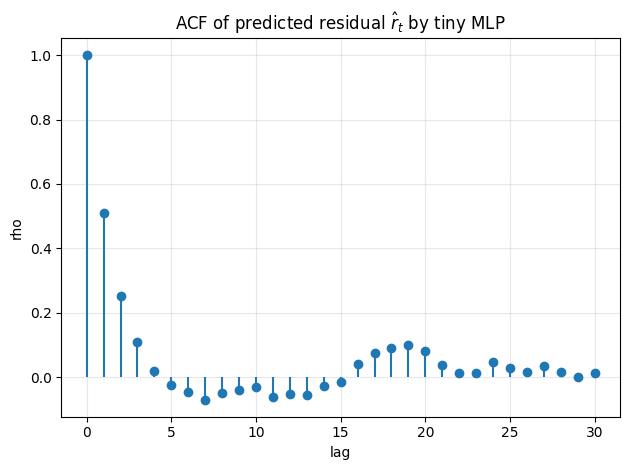

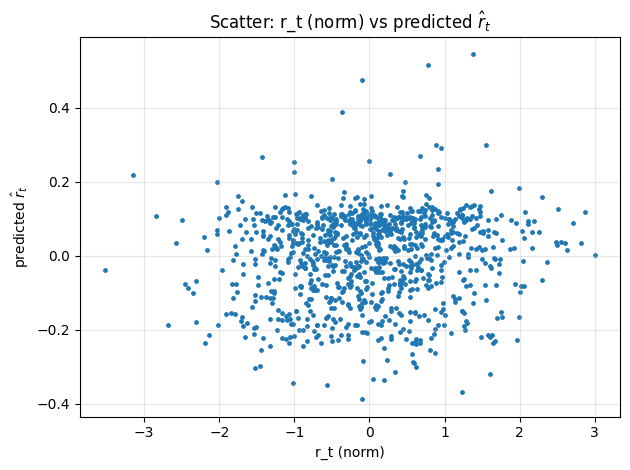

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# --------------------
# Utilities
# --------------------
def zscore(x):
    x = np.asarray(x, dtype=np.float64)
    mu = x.mean()
    sd = x.std() + 1e-12
    return (x - mu) / sd, mu, sd

def acf_1d(x, max_lag=40):
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    var = np.dot(x, x) / len(x)
    if var <= 0 or len(x) == 0:
        return np.zeros(max_lag+1)
    ac = np.correlate(x, x, mode="full")
    mid = len(ac) // 2
    ac = ac[mid: mid + max_lag + 1] / (len(x) * var)
    return ac

def fit_ar2_ls(x):
    """
    Least-squares AR(2) fit on a 1D series x.
    x should already be standardized (z-scored).
    """
    x = np.asarray(x, dtype=np.float64)
    T = len(x)
    y = x[2:]
    X = np.stack([x[1:-1], x[:-2]], axis=1)  # (T-2, 2) for [x_{t-1}, x_{t-2}]
    # Solve least squares
    phi, *_ = np.linalg.lstsq(X, y, rcond=None)
    phi1, phi2 = phi[0], phi[1]
    return float(phi1), float(phi2)

def make_dataset_for_residual_pred(x_norm, r_norm):
    """
    Build supervised pairs for self-supervised residual prediction:
    Input: [x_{t-1}, x_{t-2}]  (causal, no leakage)
    Target: r_t
    """
    T = len(x_norm)
    X_list = []
    Y_list = []
    for t in range(2, T):
        X_list.append([x_norm[t-1], x_norm[t-2]])
        Y_list.append(r_norm[t])
    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32).reshape(-1, 1)
    return X, Y

class TinyMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=64, out_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_dim)
    def forward(self, z):
        h = F.gelu(self.fc1(z))
        # Gaussian Error Linear Unit
        h = F.gelu(self.fc2(h))
        out = self.fc3(h)
        return out

# --------------------
# Prepare global series x_t from noise0 
# --------------------
try:
    noise0  # noqa
    # noise0 expected shape (T, X, Y)
    arr = np.array(noise0)
    assert arr.ndim == 3 and arr.shape[0] >= 64, "noise0 must be (T, X, Y) with T>=64"
    x_t = arr.mean(axis=(1,2)).astype(np.float64)
    source_info = f"Used provided noise0 with shape {arr.shape}"
except Exception as e:
    raise e

# --------------------
# Step 0: standardize x_t
# --------------------
# AR尺度敏感
# 进入之前全局标准化
x_norm, mu_x, sd_x = zscore(x_t)

# --------------------
# Step 1: fit AR(2) and whiten
# --------------------
phi1, phi2 = fit_ar2_ls(x_norm)
r = x_norm.copy()
for t in range(2, len(x_norm)):
    r[t] = x_norm[t] - (phi1 * x_norm[t-1] + phi2 * x_norm[t-2])

# --------------------
# Step 2: standardize residual
# --------------------
# rt = xt - xt_bar AR(2)
# rt是训练目标
# 标准化保证梯度平稳
r_norm, mu_r, sd_r = zscore(r)

# --------------------
# Step 3: dataset for residual prediction (self-supervised)
# --------------------
X, Y = make_dataset_for_residual_pred(x_norm, r_norm)

# Train/val split
n = len(X)
n_train = int(0.8*n)
X_train, Y_train = X[:n_train], Y[:n_train]
X_val, Y_val = X[n_train:], Y[n_train:]

# --------------------
# Step 4: train tiny MLP with progress bar
# --------------------
torch.manual_seed(0)
model = TinyMLP(in_dim=2, hidden=64, out_dim=1)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_train_t = torch.from_numpy(X_train)
Y_train_t = torch.from_numpy(Y_train)
X_val_t = torch.from_numpy(X_val)
Y_val_t = torch.from_numpy(Y_val)

epochs = 200
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc="Training MLP (predict r_t from past x)", ncols=80):
    model.train()
    opt.zero_grad()
    pred = model(X_train_t)
    loss = loss_fn(pred, Y_train_t)
    loss.backward()
    opt.step()

    model.eval()
    with torch.no_grad():
        pred_val = model(X_val_t)
        vloss = loss_fn(pred_val, Y_val_t).item()
        train_losses.append(loss.item())
        val_losses.append(vloss)

# --------------------
# Step 5: evaluation & plots
# --------------------

# ACFs: x_norm, r_norm, and model-predicted residual \hat r_t
with torch.no_grad():
    rhat_all = model(torch.from_numpy(X)).squeeze(1).numpy()

acf_x = acf_1d(x_norm, max_lag=30)
acf_r = acf_1d(r_norm, max_lag=30)
acf_rhat = acf_1d(rhat_all, max_lag=30)

# 1) Training curves
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("Training/Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 2) ACF of x_norm
plt.figure()
lags = np.arange(len(acf_x))
plt.stem(lags, acf_x, basefmt=" ")
plt.title("ACF of x_t (standardized)")
plt.xlabel("lag")
plt.ylabel("rho")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 3) ACF of residual r_norm
plt.figure()
lags = np.arange(len(acf_r))
plt.stem(lags, acf_r, basefmt=" ")
plt.title("ACF of residual r_t (standardized after whitening)")
plt.xlabel("lag")
plt.ylabel("rho")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 4) ACF of model prediction rhat
plt.figure()
lags = np.arange(len(acf_rhat))
plt.stem(lags, acf_rhat, basefmt=" ")
plt.title("ACF of predicted residual $\hat r_t$ by tiny MLP")
plt.xlabel("lag")
plt.ylabel("rho")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 5) Scatter: r_norm vs rhat (visual goodness-of-fit)
plt.figure()
plt.scatter(r_norm[2:], rhat_all, s=6)  # align indices (rhat starts at t>=2)
plt.title("Scatter: r_t (norm) vs predicted $\hat r_t$")
plt.xlabel("r_t (norm)")
plt.ylabel("predicted $\hat r_t$")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Print a small textual summary
summary = {
    "data_source": source_info,
    "phi1": phi1,
    "phi2": phi2,
    "train_loss_last": train_losses[-1],
    "val_loss_last": val_losses[-1],
    "acf_x_lag1": float(acf_x[1]),
    "acf_x_lag2": float(acf_x[2]),
    "acf_r_lag1": float(acf_r[1]),
    "acf_r_lag2": float(acf_r[2]),
    "acf_rhat_lag1": float(acf_rhat[1]),
    "acf_rhat_lag2": float(acf_rhat[2]),
}
summary


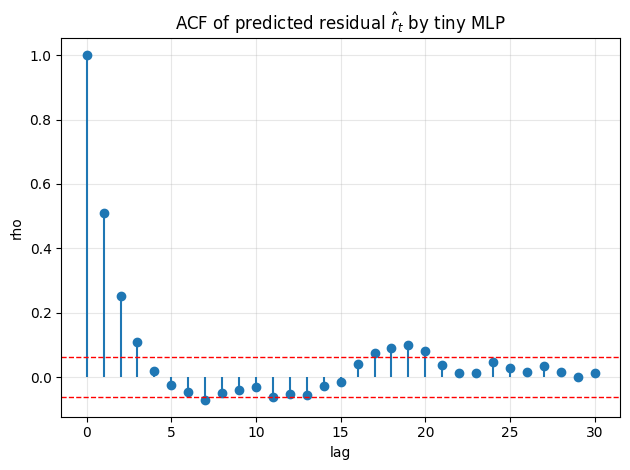

In [5]:
# the plot for predicted rt and lag with CI for white noise
# 4) ACF of model prediction rhat + white-noise CI
plt.figure()
lags = np.arange(len(acf_rhat))
plt.stem(lags, acf_rhat, basefmt=" ")

# --- White-noise 95% CI ---
N = len(rhat_all)           # length of predicted residual series
ci = 1.96 / np.sqrt(N)      # ±95% confidence interval
plt.axhline(ci,  color='red', linestyle='--', linewidth=1)
plt.axhline(-ci, color='red', linestyle='--', linewidth=1)

plt.title("ACF of predicted residual $\hat r_t$ by tiny MLP")
plt.xlabel("lag")
plt.ylabel("rho")

plt.grid(True, alpha=0.3)
plt.tight_layout()
 

Project 7: Latent Dynamics for Forecasting with Generative Models Project Supervisor: Martin Andrae martin.andrae@liu.se

Flow-based generative models learn to transform simple random noise (typically from a standard normal distribution) into complex data, like images or physical states. This is done using a smooth, reversible mapping described by an ODE. By reversing this mapping, we can encode data back into a *latent space*—a simplified representation where structure may be easier to analyze.

In this project, we apply this idea to a spatiotemporal system governed by a chaotic PDE. A pre-trained generative model is used to map physical states into latents, and your task is to investigate the properties and dynamics of these latent representations. The goal is to better understand whether the latent space can support probabilistic forecasting.

Project Goals (choose one or combine):

1. Learn the latent dynamics Treat the latent trajectory as a time series. Try fitting a simple predictive model that learns how the latents evolve over time. Start with basic regression (e.g., linear or autoregressive models), and optionally explore more flexible approaches like neural networks.

2. Analyze the latent distribution Check whether the latent states follow a standard Gaussian distribution (as they ideally should). Use tools like histograms, Q-Q plots, or correlation analysis to test this. Consider both the spatial and temporal structure in the latent trajectories.

3. Explore interpolation and sampling Latent interpolations often yield meaningful transitions in physical space when decoded. Traditionally, these are done via linear interpolation, but stochastic approaches (e.g., Brownian bridges) may offer richer insights. Similarly, sampling near a known latent can generate realistic nearby states. Explore and quantify how different interpolation and sampling methods affect the decoded outputs. Note: Requires a GPU-capable laptop and some experience with PyTorch.

项目叙述或许对我们的下一步方向有帮助